[View in Colaboratory](https://colab.research.google.com/github/rodgzilla/machine_learning_pytorch_deep_image_prior/blob/master/Deep_Image_Prior_public.ipynb)

In [0]:
`#@title Default title text
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import PIL
import numpy as np
from google.colab import files
import io

In [3]:
uploaded = files.upload()

Saving dog.jpg to dog (1).jpg


In [0]:
virtual_file = io.BytesIO(list(uploaded.values())[0]) 

(256, 256, 3)


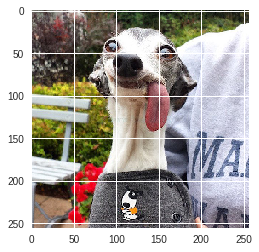

In [5]:
img = np.array(PIL.Image.open(virtual_file).resize((256, 256)))
print(img.shape)
plt.imshow(img)

In [0]:
cuda = True

In [0]:
encoding_size = 1000

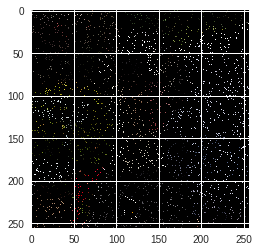

In [8]:
mask          = (np.random.random((256, 256)) < 0.05).astype(np.int32)
mask          = np.expand_dims(mask, -1)
mask_variable = Variable(torch.Tensor(np.transpose(mask, (2, 0, 1))))
mask_variable = mask_variable.cuda() if cuda else mask_variable
plt.imshow((img * mask).astype(np.uint8))

In [0]:
def show_img(tensor):
    img = (tensor * 127.5 + 127.5).numpy().astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

In [0]:
def compare_images(img, mask, tensor):
    plt.figure(figsize = (18, 12))
    plt.subplot(1, 3, 1)
    plt.title('Original image')
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.title('Corrupted image')
    plt.imshow((img * mask).astype(np.uint8))
    plt.subplot(1, 3, 3)
    plt.title('Restored image')
    img_pred = (tensor.cpu().data.squeeze() * 127.5 + 127.5).numpy().astype(np.uint8)
    img_pred = np.transpose(img_pred, (1, 2, 0))
    plt.imshow(img_pred)

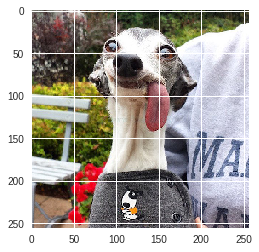

In [11]:
img_tensor = torch.Tensor(np.transpose(img, (2, 0, 1)))
img_tensor = (img_tensor - 127.5) / 127.5
show_img(img_tensor)

In [0]:
class HourglassAutoencoder(nn.Module):
    def __init__(self):
        super(HourglassAutoencoder, self).__init__()
        self.conv1            = nn.Conv2d(3  , 64 , 3, padding = 1)
        self.conv2            = nn.Conv2d(64 , 64 , 3, padding = 1)
        self.conv3            = nn.Conv2d(64 , 128, 3, padding = 1)
        self.conv4            = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv5            = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv6            = nn.Conv2d(256, 256, 3, padding = 1)
        self.conv_to_encoding = nn.Linear(256 * 32 * 32, encoding_size)
        self.encoding_to_2d   = nn.Linear(encoding_size, 64 * 64 * 3)
        self.conv7            = nn.Conv2d(259, 256, 3, padding = 1)
        self.conv8            = nn.Conv2d(512, 256, 3, padding = 1)
        self.conv9            = nn.Conv2d(384, 128, 3, padding = 1)
        self.conv10           = nn.Conv2d(256, 128, 3, padding = 1)
        self.conv11           = nn.Conv2d(128, 64 , 3, padding = 1)
        self.conv12           = nn.Conv2d(64 , 64 , 3, padding = 1)
        self.conv13           = nn.Conv2d(64 , 3  , 3, padding = 1)
    
    def forward(self, x):
        out_conv1      = F.relu(self.conv1(x))
        out_conv2      = F.relu(self.conv2(out_conv1))
        out_avg_pool1  = F.avg_pool2d(out_conv2, (2, 2))
        out_conv3      = F.relu(self.conv3(out_avg_pool1))
        out_conv4      = F.relu(self.conv4(out_conv3))
        out_avg_pool2  = F.avg_pool2d(out_conv4, (2, 2))
        out_conv5      = F.relu(self.conv5(out_avg_pool2))
        out_conv6      = F.relu(self.conv6(out_conv5))
        out_avg_pool3  = F.avg_pool2d(out_conv6, (2, 2))
        out_flatten    = out_avg_pool3.view(1, 256 * 32 * 32)
        encoding       = F.relu(self.conv_to_encoding(out_flatten))
        decoding_start = F.relu(self.encoding_to_2d(encoding))
        decoding_img   = decoding_start.view(1, 3, 64, 64)
        in_conv7       = torch.cat([out_conv6, decoding_img], dim = 1)
        out_conv7      = F.relu(self.conv7(in_conv7))
        in_conv8       = torch.cat([out_conv5, out_conv7], dim = 1)
        out_conv8      = F.relu(self.conv8(in_conv8))
        out_upsample1  = F.upsample(out_conv8, scale_factor = 2)
        in_conv9       = torch.cat([out_conv4, out_upsample1], dim = 1)
        out_conv9      = F.relu(self.conv9(in_conv9))
        in_conv10      = torch.cat([out_conv3, out_conv9], dim = 1)
        out_conv10     = F.relu(self.conv10(in_conv10))
        out_upsample2  = F.upsample(out_conv10, scale_factor = 2)
        out_conv11     = F.relu(self.conv11(out_upsample2))
        out_conv12     = F.relu(self.conv12(out_conv11))
        out_conv13     = F.tanh(self.conv13(out_conv12))
        
        return out_conv13

In [0]:
def inpainting_loss(mask):
    def mse_loss_mask(img_pred, img_true):
        return (((img_pred - img_true) ** 2) * mask).mean()
    
    return mse_loss_mask

In [0]:
autoencoder = HourglassAutoencoder()
autoencoder = autoencoder.cuda() if cuda else autoencoder
criterion   = inpainting_loss(mask_variable)
optimizer   = optim.Adam(autoencoder.parameters())

In [15]:
img_variable = Variable(img_tensor.unsqueeze(0))
img_variable = img_variable.cuda() if cuda else img_variable
input_image  = Variable(torch.rand(img_variable.size()))
input_image  = input_image.cuda() if cuda else input_image
for i in range(1500):
    optimizer.zero_grad()
    img_pred = autoencoder(input_image)
    loss     = criterion(img_pred, img_variable)
    loss.backward()
    optimizer.step()
    if i % 50 == 49:
        print(f'[{i + 1:^5}]: {loss.data[0]:.6f}')

[ 50  ]: 0.009304
[ 100 ]: 0.002201
[ 150 ]: 0.000594
[ 200 ]: 0.000201
[ 250 ]: 0.000087
[ 300 ]: 0.000048
[ 350 ]: 0.000038
[ 400 ]: 0.000022
[ 450 ]: 0.000017
[ 500 ]: 0.000052
[ 550 ]: 0.000010
[ 600 ]: 0.000028
[ 650 ]: 0.000010
[ 700 ]: 0.000004
[ 750 ]: 0.000005
[ 800 ]: 0.000005
[ 850 ]: 0.000059
[ 900 ]: 0.000004
[ 950 ]: 0.000004
[1000 ]: 0.000002
[1050 ]: 0.000003
[1100 ]: 0.000002
[1150 ]: 0.000003
[1200 ]: 0.000002
[1250 ]: 0.000008
[1300 ]: 0.000001
[1350 ]: 0.000003
[1400 ]: 0.000001
[1450 ]: 0.000001
[1500 ]: 0.000001


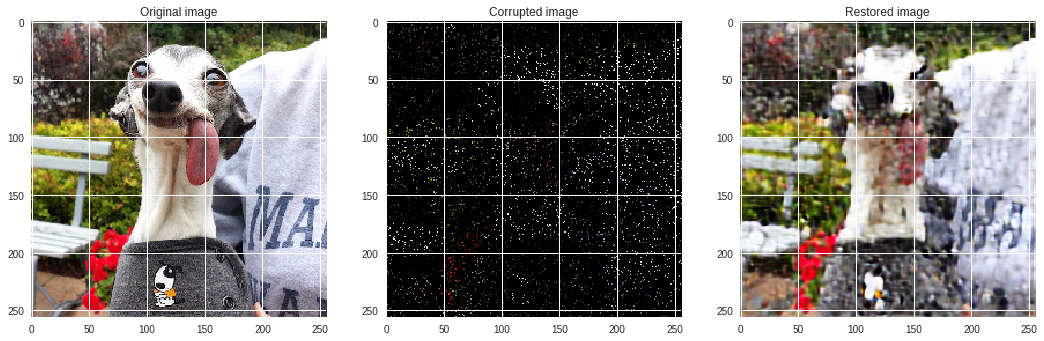

In [16]:
compare_images(img, mask, img_pred)